In [1]:
import numpy as np
import networkx as nx
import unicodecsv as csv
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
path = "hero-network.csv"

In [3]:
def graph_from_csv(path):
    graph = nx.Graph(name="Heroic Social Network")
    with open(path, "rU") as data:
        reader = csv.reader(data)
        for row in reader:
            graph.add_edge(*row)
    return graph

In [73]:
graph = graph_from_csv(path)

In [74]:
print "Order of graph:", graph.order()
print "Size of graph:", graph.number_of_edges()

Order of graph: 6426
Size of graph: 167219


In [70]:
print "Average degree of ", np.mean(graph.degree().values())

Average degree of  52.0445066916


In [11]:
def graph_from_gdf(path):
    graph = nx.Graph(name="Characters in Comics")
    with open(path, 'rU') as data:
        reader = csv.reader(data)
        for row in reader:
            if 'nodedef' in row[0]:
                handler = lambda row,G: G.add_node(row[0],
                    TYPE=row[1])
            elif 'edgedef' in row[0]:
                handler = lambda row,G: G.add_edge(*row)
            else:
                handler(row, graph)
    return graph

In [72]:
graph = graph_from_gdf("comic-hero-network.gdf.txt")

Create a function to draw a graph of nodes with certain number of steps within a social network.

In [19]:
def draw_ego_Graph(graph, character, hops=1):
    ego = nx.ego_graph(graph, character, hops)
    pos = nx.spring_layout(ego)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    
    ego.node[character]["TYPE"] = "center"
    valmap = {"comic":0.25, "hero":0.54, "center":0.87}
    types = nx.get_node_attributes(ego, "TYPE")
    values = [valmap.get(types[node], 0.25) for node in ego.nodes()]
    
    nx.draw_networkx_edges(ego, pos, alpha=0.4)
    nx.draw_networkx_nodes(ego, pos, node_size=80, node_color=values, cmap=plt.cm.hot, with_labels=False)
    plt.show()

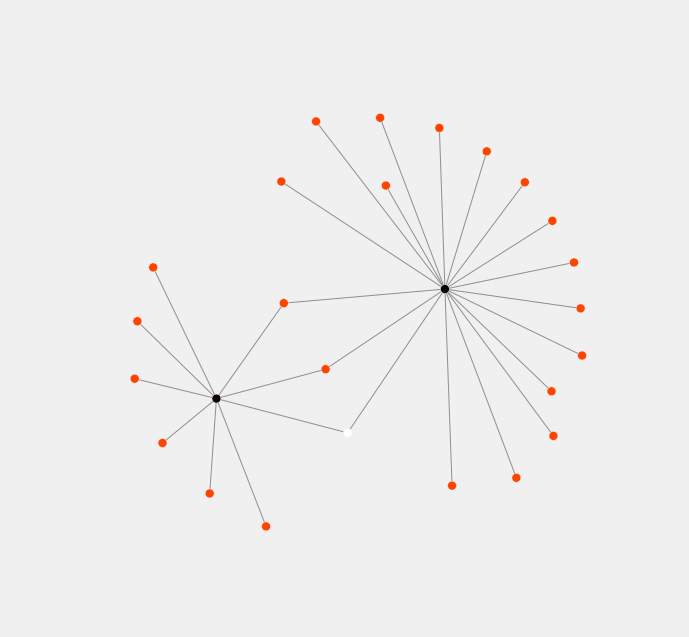

In [54]:
draw_ego_Graph(graph, "LONGBOW/AMELIA GREER", 2)

Transofrm the unweighted graph to a weighted graph where the weight of a particular node is inversely related to the degree of the comic book divided by 2. If a comic book has more characters in it, the characters in that comic book should be more loosely connected than if there were only a few characters. 

In [26]:
def transform_to_weighted_heros(comics, outpath="weighted_heros.csv"):
    # Create new graph to fill in
    heros = nx.Graph(name="Weighted Heroic Social Network")

    # Iterate through all the nodes and their properties
    for node, data in graph.nodes(data=True):
        # We don't care about comics, only heros
        if data['TYPE'] == 'comic': continue
        # Add the hero and their properties (this will also update data)
        heros.add_node(node, **data) # Add or update nodes

        # Find all the heros connected via the comic books
        for comic in graph[node]:
            for alter in graph[comic]:
                # Skip the same hero in the comic
                if alter == node: continue

                # Setup the default edge
                if alter not in heros[node]:
                    heros.add_edge(node, alter, weight=0.0, label="knows")

                # The weight of the hero is the fraction of connections / 2
                heros[node][alter]["weight"] += 1.0 / (graph.degree(comic) *2)
    return heros

In [50]:
def draw_weighted_ego_graph(graph, character, hops=1):
    ego = nx.ego_graph(graph, character, hops)
    pos = nx.spring_layout(ego)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    
    ego.node[character]["TYPE"] = "center"
    valmap = {"hero":0.0, "center":1.0}
    types = nx.get_node_attributes(ego, "TYPE")
    values = [valmap.get(types[node], 0.25) for node in ego.nodes()]
    char_edges = ego.edges(data=True, nbunch=[character, ])
    nonchar_edges = ego.edges(nbunch=[n for n in ego.nodes() if n != character])
    elarge = [(u, v) for (u, v, d)in char_edges if d["weight"] >= 0.12]
    esmall = [(u, v) for (u, v, d) in char_edges if d["weight"] < 0.12]
    #print set([d['weight'] for (u, v, d) in char_edges])
    
    nx.draw_networkx_nodes(ego, pos, node_size=200, node_color=values, cmap=plt.cm.Paired, with_labels=False)
    nx.draw_networkx_edges(ego, pos, edgelist=elarge, width=1.5, edge_color="b")
    nx.draw_networkx_edges(ego, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="dashed")
    nx.draw_networkx_edges(ego, pos, edgelist=nonchar_edges, width=0.5, alpha=0.2, style="dashed")
    plt.show()

In [55]:
wheros = transform_to_weighted_heros(graph)

set([0.125, 0.0625, 0.3694889167505801, 0.03125, 0.6921424907408888, 0.8695346320346319, 9.935096870912762, 0.5185897435897436, 0.909148942844595, 0.25770891325811235, 0.7905159127068639, 0.3476744961265085, 0.5, 0.39549470847424806, 26.12545073354558, 0.8357503607503608, 0.5162170131210378, 25.17014377047523, 0.1116938616938617, 0.31583000333000333, 0.49544621692199486, 0.19668406853761547, 0.3282075054181952, 0.712331559371247, 0.3500180375180375, 0.9666416916416914, 0.043156059285091544, 0.20202559929510547, 0.1573300573300573, 0.25247432306255835, 0.06349206349206349, 0.6684561096693824, 0.7478187447227694, 0.2104889247842539, 1.332243611220659, 0.2276315789473684, 0.21984590122521158, 0.043478260869565216, 0.2539735052221179, 1.4626036573298236, 0.047619047619047616, 19.722021821936035, 1.2788556973305927, 0.10797236469461727, 0.10512820512820513, 0.10644257703081234, 0.04550326188257223, 0.25274911136656913, 0.21978021978021978, 0.05543345543345543, 0.2227106227106227, 0.38679828

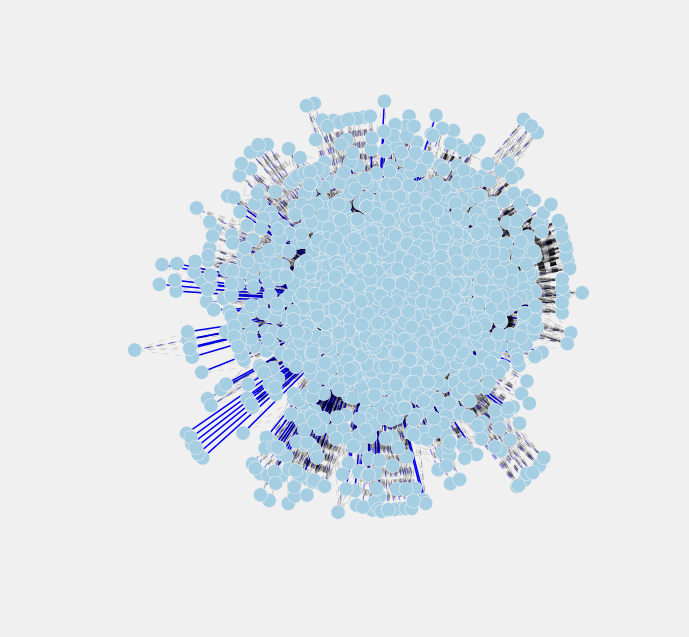

In [47]:
draw_weighted_ego_graph(wheros, "CAPTAIN AMERICA")

In [46]:
for n in graph.nodes():
    if len(graph[n]) > 500:
        print n

SUB-MARINER/NAMOR MA
MR. FANTASTIC/REED R
ANT-MAN/DR. HENRY J.
WATSON-PARKER, MARY
DAREDEVIL/MATT MURDO
WASP/JANET VAN DYNE
HAWK
JAMESON, J. JONAH
THING/BENJAMIN J. GR
DR. STRANGE/STEPHEN
VISION
BEAST/HENRY &HANK& P
CAPTAIN AMERICA
STORM/ORORO MUNROE S
THOR/DR. DONALD BLAK
CYCLOPS/SCOTT SUMMER
HULK/DR. ROBERT BRUC
WOLVERINE/LOGAN
INVISIBLE WOMAN/SUE
SCARLET WITCH/WANDA
SPIDER-MAN/PETER PARKER
HUMAN TORCH/JOHNNY S
IRON MAN/TONY STARK


In [48]:
import operator

Look at heroes vs. their degree in network in descending order.

In [49]:
degrees = sorted(graph.degree().items(), key=operator.itemgetter(1), reverse=True)
for node in degrees:
    print node

(u'SPIDER-MAN/PETER PARKER', 1577)
(u'CAPTAIN AMERICA', 1334)
(u'IRON MAN/TONY STARK', 1150)
(u'THING/BENJAMIN J. GR', 963)
(u'THOR/DR. DONALD BLAK', 956)
(u'HUMAN TORCH/JOHNNY S', 886)
(u'MR. FANTASTIC/REED R', 854)
(u'HULK/DR. ROBERT BRUC', 835)
(u'WOLVERINE/LOGAN', 819)
(u'INVISIBLE WOMAN/SUE', 762)
(u'SCARLET WITCH/WANDA', 643)
(u'BEAST/HENRY &HANK& P', 635)
(u'DR. STRANGE/STEPHEN', 631)
(u'WATSON-PARKER, MARY', 622)
(u'DAREDEVIL/MATT MURDO', 619)
(u'HAWK', 605)
(u'VISION', 603)
(u'CYCLOPS/SCOTT SUMMER', 585)
(u'WASP/JANET VAN DYNE', 581)
(u'JAMESON, J. JONAH', 577)
(u'ANT-MAN/DR. HENRY J.', 561)
(u'SUB-MARINER/NAMOR MA', 530)
(u'STORM/ORORO MUNROE S', 523)
(u'PROFESSOR X/CHARLES', 496)
(u'FURY, COL. NICHOLAS', 471)
(u'MARVEL GIRL/JEAN GRE', 466)
(u'COLOSSUS II/PETER RA', 452)
(u'NIGHTCRAWLER/KURT WA', 444)
(u'ANGEL/WARREN KENNETH', 444)
(u'ICEMAN/ROBERT BOBBY', 427)
(u'SHE-HULK/JENNIFER WA', 415)
(u'JARVIS, EDWIN', 399)
(u'WONDER MAN/SIMON WIL', 390)
(u'BLACK WIDOW/NATASHA', 384)


Compute centrality for top nodes: the percent of nodes in the graph that a node is connected to.

In [56]:
centrality = nx.degree_centrality(graph)
nx.set_node_attributes(graph, "centrality", centrality)
degrees = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
for item in degrees[0:15]: 
    print "%s: %0.4f" % item

SPIDER-MAN/PETER PARKER: 0.0826
CAPTAIN AMERICA: 0.0699
IRON MAN/TONY STARK: 0.0602
THING/BENJAMIN J. GR: 0.0504
THOR/DR. DONALD BLAK: 0.0501
HUMAN TORCH/JOHNNY S: 0.0464
MR. FANTASTIC/REED R: 0.0447
HULK/DR. ROBERT BRUC: 0.0437
WOLVERINE/LOGAN: 0.0429
INVISIBLE WOMAN/SUE: 0.0399
SCARLET WITCH/WANDA: 0.0337
BEAST/HENRY &HANK& P: 0.0333
DR. STRANGE/STEPHEN: 0.0331
WATSON-PARKER, MARY: 0.0326
DAREDEVIL/MATT MURDO: 0.0324


(array([  8.51000000e+03,   3.66100000e+03,   2.48000000e+03,
          1.59400000e+03,   9.18000000e+02,   5.85000000e+02,
          4.15000000e+02,   1.57000000e+02,   9.90000000e+01,
          7.90000000e+01,   6.50000000e+01,   5.90000000e+01,
          4.20000000e+01,   3.80000000e+01,   2.50000000e+01,
          2.30000000e+01,   1.50000000e+01,   2.00000000e+01,
          1.80000000e+01,   1.20000000e+01,   1.40000000e+01,
          6.00000000e+00,   1.60000000e+01,   7.00000000e+00,
          6.00000000e+00,   9.00000000e+00,   1.20000000e+01,
          8.00000000e+00,   7.00000000e+00,   4.00000000e+00,
          8.00000000e+00,   5.00000000e+00,   8.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   1.00000000e+01,
          5.00000000e+00,   6.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          6.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   1.00000000e+00,
        

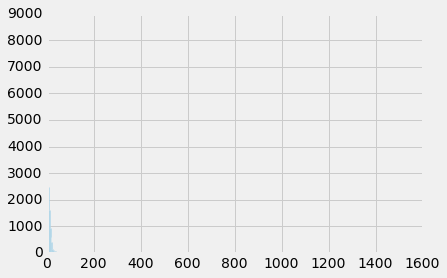

In [58]:
filter(lambda v: v < 500, graph.degree().values())
plt.hist(graph.degree().values(), bins=500)

Create a function to output the top 10 nodes based on a user-specificed centrality metric.

In [59]:
def nbest_centrality(graph, metric, n = 10, attribute="centrality", **kwargs):
    centrality = metric(graph, **kwargs)
    nx.set_node_attributes(graph, attribute, centrality)
    degrees = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
    for idx, item in enumerate(degrees[0:n]):
        item = (idx + 1, ) + item
        print "%i. %s: %0.4f" % item

In [60]:
nbest_centrality(graph, nx.degree_centrality)

1. SPIDER-MAN/PETER PARKER: 0.0826
2. CAPTAIN AMERICA: 0.0699
3. IRON MAN/TONY STARK: 0.0602
4. THING/BENJAMIN J. GR: 0.0504
5. THOR/DR. DONALD BLAK: 0.0501
6. HUMAN TORCH/JOHNNY S: 0.0464
7. MR. FANTASTIC/REED R: 0.0447
8. HULK/DR. ROBERT BRUC: 0.0437
9. WOLVERINE/LOGAN: 0.0429
10. INVISIBLE WOMAN/SUE: 0.0399


In [63]:
import scipy.stats as st

In [75]:
data = np.array(graph.degree().values())

In [77]:
st.mode(data)

ModeResult(mode=array([11]), count=array([254]))

Density of a graph is the ratio of the number of edges in the graph to the total number of possible edges in the graph. This measure will range from 0 to 1. The Marvel graph is relatively sparse while looking at a particular hero's subgraph it is more dense.

In [78]:
print "Density of graph:", nx.density(graph)

Density of graph: 0.00810031232554


In [79]:
ego = nx.ego_graph(graph, "LONGBOW/AMELIA GREER")

In [80]:
print "Longbow graph density:", nx.density(ego)

Longbow graph density: 0.721014492754
